# `SGD neural net with Numba Jit`

In [1]:
import numpy as np
from numpy.linalg import norm
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

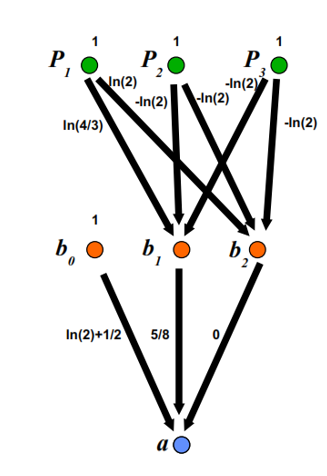

# Q1

## Part a

$$
P = (1,1,1)^T \\
\\[10pt]
X_1 = \ln\left(\frac{4}{3}\right) - \ln 2 - \ln 2, \quad  X_2 = -\ln 2 - \ln 2 + \ln 2 \\
\\[10pt]
b_1 = \tanh(X_1) = -0.8,  \quad b_2 = \tanh(X_2) = -0.6 \\
\\[10pt]
Z = \frac{5}{8} \cdot (-0.8) + \ln 2 + 0.5 = \ln 2 \\
\\[10pt]
a = \tanh(Z) = 0.6
$$


***

## Part b

Real value: $y_0 = -1$

$\eta = 1$

a = 0.6

*First update:*

$$
\epsilon = \frac{1}{2} (tanh(Z) - y_0)^2 = \frac{1}{2} (tanh(w_1 \cdot tanh(X_1) + w_2 \cdot tanh(X_2) + w_0) - y_0)^2
\\[10pt]
\frac{\partial \epsilon}{\partial w_0} = (tanh(Z)- y_0) \cdot (1-tanh(Z)^2) \cdot 1
\\[10pt]
\frac{\partial \epsilon}{\partial w_2} = (tanh(Z)- y_0) \cdot (1-tanh(Z)^2) \cdot tanh(X_2)
\\[10pt]
\frac{\partial \epsilon}{\partial w_1} = (tanh(Z)- y_0) \cdot (1-tanh(Z)^2) \cdot tanh(X_1)
\\[15pt]
\text{Now, Let's update the weights:}
\\[10pt]
w_1^{t+1} = w_1^t - \eta \cdot \frac{\partial \epsilon}{\partial w_1} \Rightarrow \quad w_1^{(1)} =  w_1^{(0)} - \eta \cdot \frac{\partial \epsilon}{\partial w_1} = 5/8 - 1 \cdot (0.6 + 1) \cdot (1-0.6^2) \cdot (-0.8) = 1.442
\\[10pt]
w_2^{t+1} = w_2^t - \eta \cdot \frac{\partial \epsilon}{\partial w_2} \Rightarrow \quad w_2^{(1)} =  w_2^{(0)} - \eta \cdot \frac{\partial \epsilon}{\partial w_2} =  0 - 1 \cdot (0.6 + 1) \cdot (1-0.6^2) \cdot (-0.6) = 0.6144
\\[10pt]
w_0^{t+1} = w_0^t - \eta \cdot \frac{\partial \epsilon}{\partial w_0} \Rightarrow \quad w_0^{(1)} =  w_0^{(0)} - \eta \cdot \frac{\partial \epsilon}{\partial w_0} =  ln(2) + 0.5 - 1 \cdot (0.6 + 1) \cdot (1-0.6^2) \cdot 1 = 0.169
$$



***

# Q3

We're implementing an SGD neural net for approximating the renown matlab Peaks function, We've added a constant neuron to the input.

We ran this model 100 times to find the lowest error 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

def peaks(x, y):
    term1 = 3 * (1 - x)**2 * np.exp(-(x**2) - (y + 1)**2)
    term2 = -10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2)
    term3 = -1/3 * np.exp(-(x + 1)**2 - y**2)
    return term1 + term2 + term3

# Generate a grid of points
A = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(A, A)
Z = peaks(X, Y)

# Flatten the grid and sample 1000 points
data = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
np.random.shuffle(data)
sample_size = 1000
train_data = data[:sample_size]
X_train = train_data[:, 0:2]  # Inputs: x and y
y_train = train_data[:, 2]     # Outputs: z

# Optional: Scale target values to match tanh range (-1, 1)
# Uncomment the following lines if needed
# y_train = y_train / np.max(np.abs(y_train))

# Add bias term to inputs
X_train = np.hstack((X_train, np.ones((sample_size, 1))))  # Adding a bias input

# Initialize neural network parameters
np.random.seed(42)  # For reproducibility

input_size = 3       # 2 inputs + 1 bias
hidden_size = 100    # Number of neurons in the hidden layer
output_size = 1

W1 = np.random.randn(input_size, hidden_size) * 0.1  # Input to Hidden
W2 = np.random.randn(hidden_size, output_size) * 0.1 # Hidden to Output

# Activation functions
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1.0 - np.tanh(x)**2

# Training parameters
eta = 0.001          # Learning rate
iterations = 1000000 # Total number of training steps
sample_interval = 1000  # Interval to record error

# To store error history
error_history = []
steps = []

for step in range(1, iterations + 1):
    # Randomly select a single sample
    idx = np.random.randint(0, sample_size)
    x_sample = X_train[idx]
    y_sample = y_train[idx]

    # Forward pass
    z1 = np.dot(x_sample, W1)      # Input to Hidden (includes bias)
    a1 = tanh(z1)                   # Activation Hidden
    z2 = np.dot(a1, W2)             # Hidden to Output
    a2 = tanh(z2)                   # Tanh activation for output

    # Compute error (Mean Squared Error)
    error = 0.5 * (a2 - y_sample)**2

    # Backward pass
    delta2 = (a2 - y_sample) * tanh_derivative(z2)  # Include activation derivative
    dW2 = a1[:, np.newaxis] * delta2               # Gradient for W2

    delta1 = (delta2 * W2.flatten()) * tanh_derivative(z1)  # Gradient for hidden layer
    dW1 = np.outer(x_sample, delta1)                       # Gradient for W1

    # Update weights
    W2 -= eta * dW2
    W1 -= eta * dW1

    # Record error at specified intervals
    if step % sample_interval == 0:
        # Compute total error on the training set
        z1_train = np.dot(X_train, W1)
        a1_train = tanh(z1_train)
        z2_train = np.dot(a1_train, W2)
        a2_train = tanh(z2_train).flatten()  # Apply tanh activation
        total_error = 0.5 * np.mean((a2_train - y_train)**2)
        error_history.append(total_error)
        steps.append(step)
        if step % (sample_interval * 100) == 0:
            print(f"Step {step}, Error: {total_error}")



Step 100000, Error: 1.3704577264913405
Step 200000, Error: 1.1459929706402334
Step 300000, Error: 1.0921416617734088
Step 400000, Error: 1.0721047981803349
Step 500000, Error: 1.0607834375562193
Step 600000, Error: 1.054712646826612
Step 700000, Error: 1.0507327584152486
Step 800000, Error: 1.045569209222148
Step 900000, Error: 1.0386461565341143
Step 1000000, Error: 1.0346813428279127


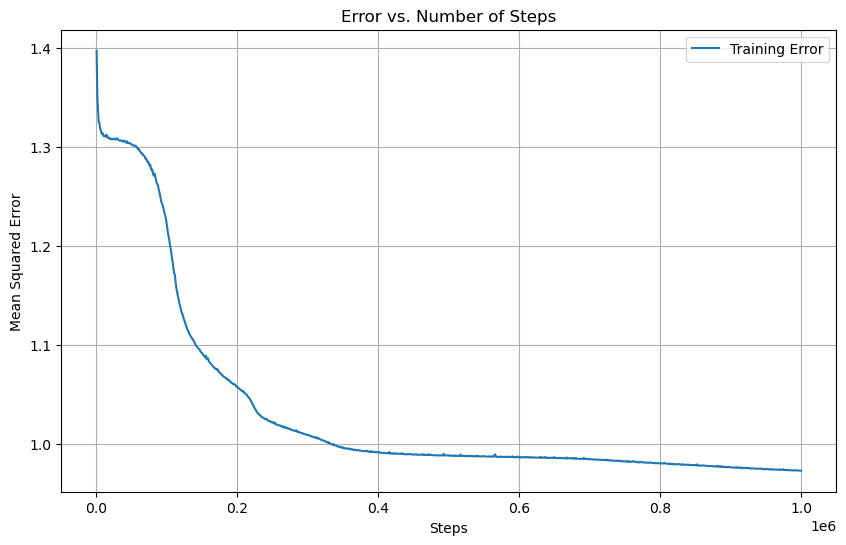

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(steps, error_history, label='Training Error')
plt.xlabel('Steps')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Number of Steps')
plt.legend()
plt.grid(True)
plt.show()


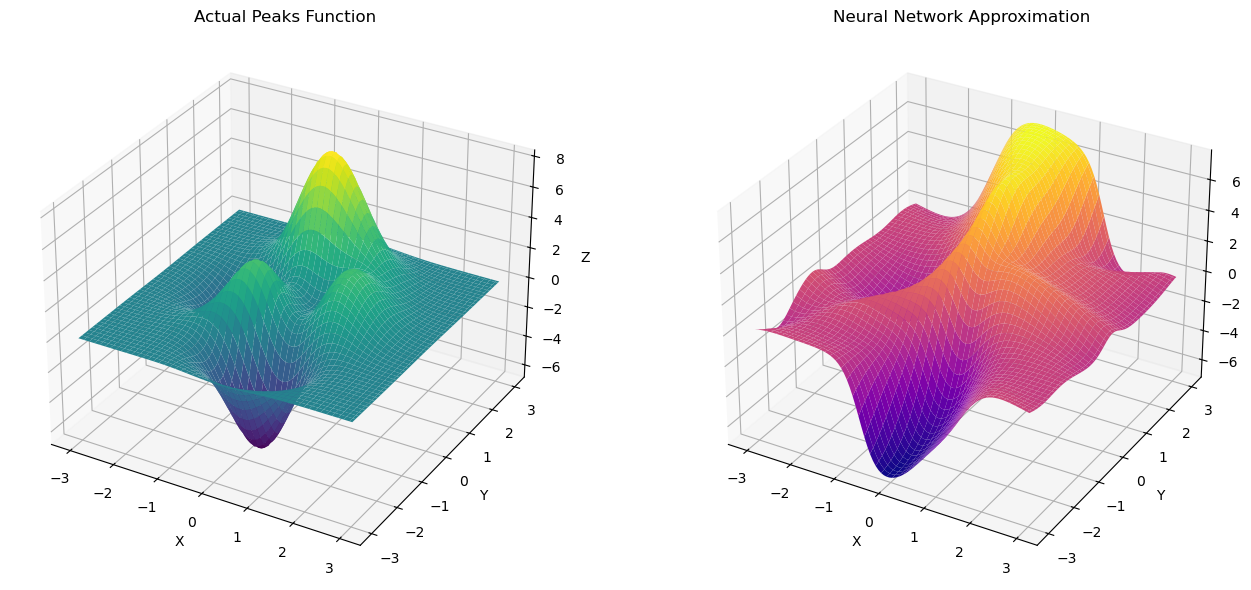

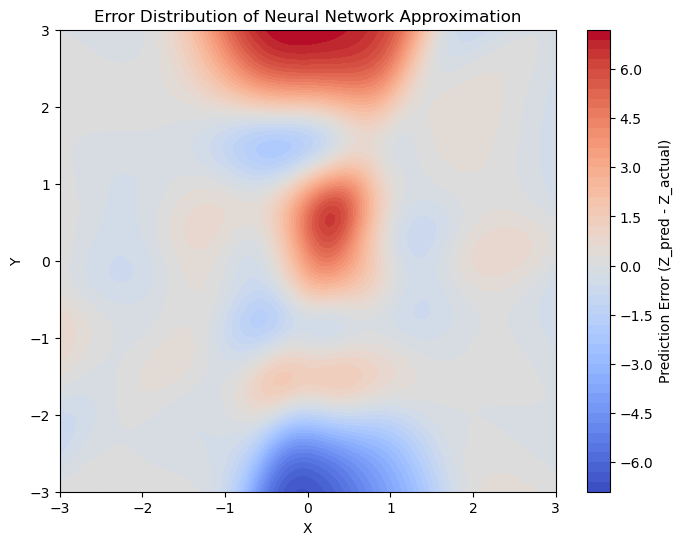

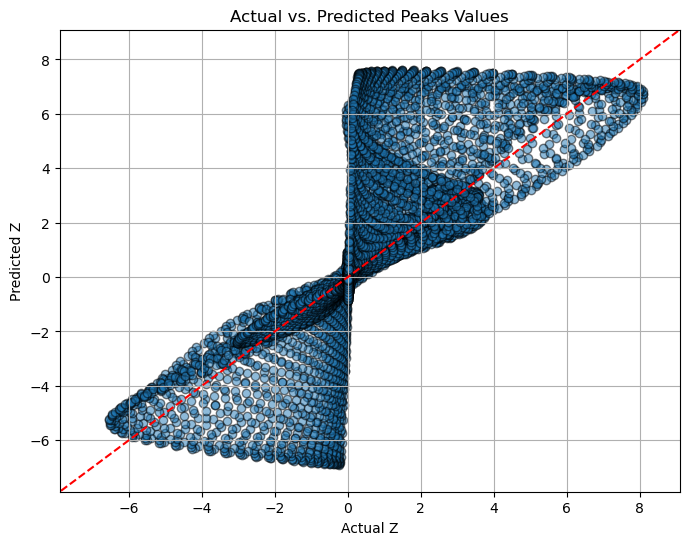

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def peaks(x, y):
    term1 = 3 * (1 - x)**2 * np.exp(-(x**2) - (y + 1)**2)
    term2 = -10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2)
    term3 = -1/3 * np.exp(-(x + 1)**2 - y**2)
    return term1 + term2 + term3

# Create a dense grid for visualization
grid_size = 100
X_grid, Y_grid = np.meshgrid(np.linspace(-3, 3, grid_size), np.linspace(-3, 3, grid_size))
Z_actual = peaks(X_grid, Y_grid)

# Prepare inputs with bias term (constant 1)
X_flat = X_grid.flatten()
Y_flat = Y_grid.flatten()
bias = np.ones_like(X_flat)  # Bias term
inputs = np.column_stack((X_flat, Y_flat, bias))  # Shape: (grid_size**2, 3)

# Forward pass for all inputs without separate bias vectors
z1_grid = np.dot(inputs, W1)       # Shape: (grid_size**2, 100)
a1_grid = np.tanh(z1_grid)        # Activation Hidden
z2_grid = np.dot(a1_grid, W2)     # Shape: (grid_size**2, 1)
Z_pred = z2_grid.reshape(X_grid.shape)  # Shape: (grid_size, grid_size)

# Plot Actual Peaks
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X_grid, Y_grid, Z_actual, cmap='viridis')
ax1.set_title('Actual Peaks Function')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot Neural Network Approximation
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X_grid, Y_grid, Z_pred, cmap='plasma')
ax2.set_title('Neural Network Approximation')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

# Compute error on the grid
error_grid = Z_pred - Z_actual

# Plot Error Distribution
plt.figure(figsize=(8, 6))
contour = plt.contourf(X_grid, Y_grid, error_grid, levels=50, cmap='coolwarm')
plt.colorbar(contour, label='Prediction Error (Z_pred - Z_actual)')
plt.title('Error Distribution of Neural Network Approximation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(Z_actual.flatten(), Z_pred.flatten(), alpha=0.5, edgecolor='k')
plt.xlabel('Actual Z')
plt.ylabel('Predicted Z')
plt.title('Actual vs. Predicted Peaks Values')
plt.plot([-10, 10], [-10, 10], 'r--')  # Diagonal line for reference
plt.grid(True)
plt.xlim(min(Z_actual.min(), Z_pred.min()) - 1, max(Z_actual.max(), Z_pred.max()) + 1)
plt.ylim(min(Z_actual.min(), Z_pred.min()) - 1, max(Z_actual.max(), Z_pred.max()) + 1)
plt.show()


# Running the model with 100 iterations using Numba Jit

***

### Quick detour:

Before we perform the code, let's elaborate on **numba jit**:

Based on the documentation at https://numba.pydata.org/numba-doc/latest/user/jit.html:

"Numba provides several utilities for code generation, but its central feature is the numba.jit() decorator. Using this decorator, you can mark a function for optimization by Numba’s JIT compiler. Various invocation modes trigger differing compilation options and behaviours."

Morover, it's stated that nopython=True "produces much faster code, but has limitations that can force Numba to fall back to the latter. To prevent Numba from falling back, and instead raise an error, pass nopython=True." njit is an alias for @jit(nopython=True).

TLDR, it makes this code wayyy faster.


***

## Our code:

New best model found in run 1. Error: 0.9101231063241371
Run 10/100 completed. Final error: 1.0641190072525677
New best model found in run 16. Error: 0.8956250585993681
Run 20/100 completed. Final error: 1.2092380865871821
New best model found in run 23. Error: 0.8748070496324825
Run 30/100 completed. Final error: 1.0927232605036854
Run 40/100 completed. Final error: 1.081292788175375
Run 50/100 completed. Final error: 0.9220731106983926
New best model found in run 53. Error: 0.8313756349495689
Run 60/100 completed. Final error: 1.0650326905331688
Run 70/100 completed. Final error: 1.140737086316949
Run 80/100 completed. Final error: 1.10985573377134
Run 90/100 completed. Final error: 1.0977701583458461
Run 100/100 completed. Final error: 1.044306906076902

All runs completed. Best run has final error: 0.8313756349495689


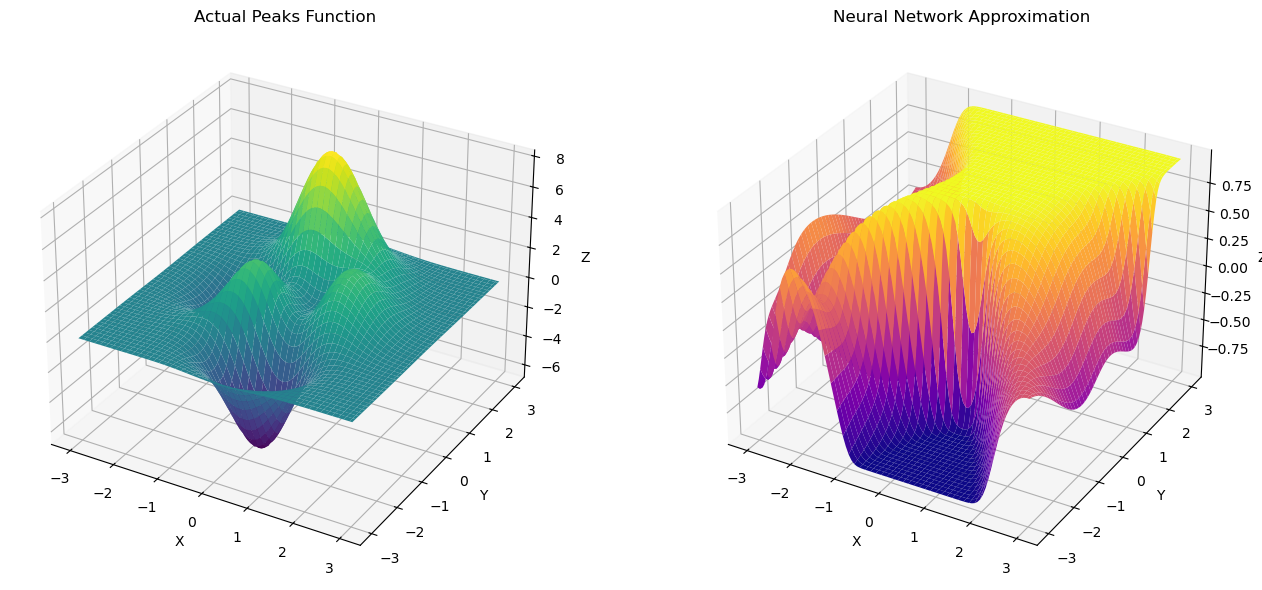

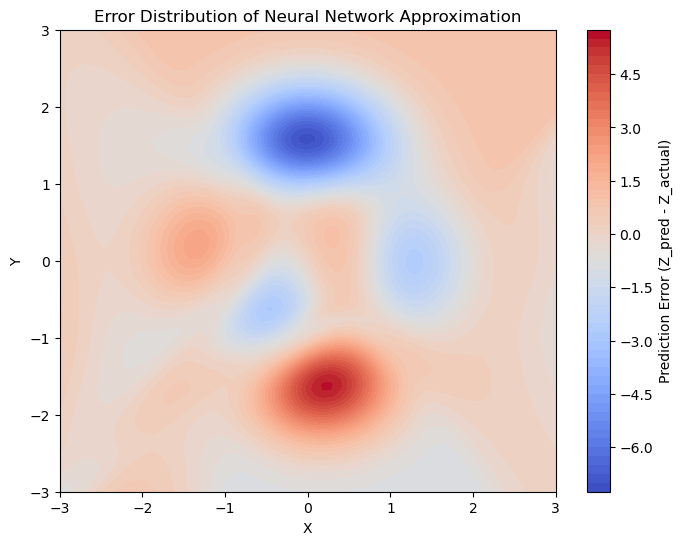

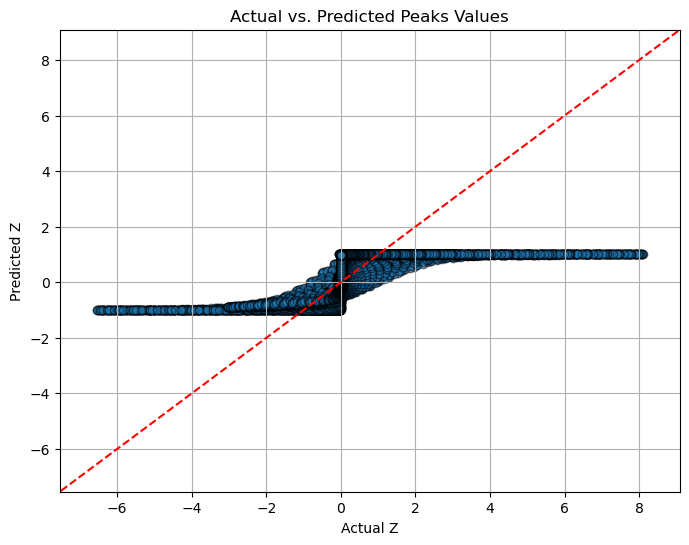

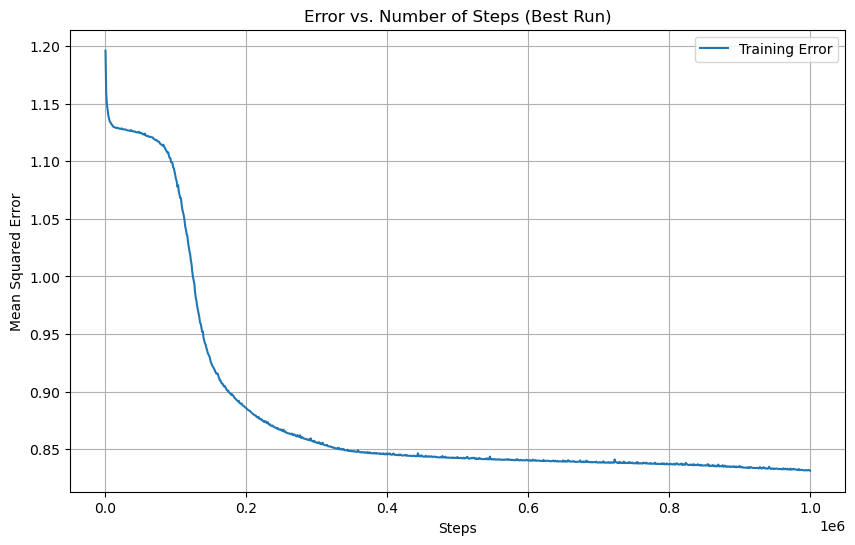

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

@njit
def peaks(x, y):
    term1 = 3.0 * (1.0 - x)**2 * np.exp(-(x**2) - (y + 1.0)**2)
    term2 = -10.0 * (x / 5.0 - x**3 - y**5) * np.exp(-x**2 - y**2)
    term3 = -1.0 / 3.0 * np.exp(-(x + 1.0)**2 - y**2)
    return term1 + term2 + term3

@njit
def initialize_weights_numba(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * 0.1  # Input to Hidden
    W2 = np.random.randn(hidden_size, output_size) * 0.1 # Hidden to Output
    return W1, W2

@njit
def tanh_numba(x):
    return np.tanh(x)

@njit
def tanh_derivative_numba(x):
    return 1.0 - np.tanh(x)**2

@njit
def forward_pass_numba(x, W1, W2):
    z1 = np.dot(x, W1)        # Input to Hidden
    a1 = np.tanh(z1)       # Activation Hidden
    z2 = np.dot(a1, W2)       # Hidden to Output
    a2 = np.tanh(z2)       # Activation Output
    return z1, a1, z2, a2

@njit
def backward_pass_numba(x, y, z1, a1, z2, a2, W2):
    # Compute delta for output layer
    delta2 = (a2 - y) * (1 - np.tanh(z2)**2)
    dW2 = a1[:, np.newaxis] * delta2

    # Compute delta for hidden layer
    delta1 = (delta2 * W2.flatten()) * (1 - np.tanh(z1)**2)
    dW1 = np.outer(x, delta1)

    return dW1, dW2

@njit
def train_one_run(X_train, y_train, W1,W2,hidden_size=100, eta=0.001, iterations=1000000, sample_interval=1000):
    input_size = X_train.shape[1]  # 3 (x, y, bias)
    output_size = 1

    

    # To store error history
    error_history = []
    steps_recorded = []

    for step in range(1, iterations + 1):
        # Randomly select a single sample
        idx = np.random.randint(0, sample_size)
        x_sample = X_train[idx]
        y_sample = y_train[idx]

        # Forward pass
        z1 = np.dot(x_sample, W1)      # Input to Hidden (includes bias)
        a1 = tanh_numba(z1)                   # Activation Hidden
        z2 = np.dot(a1, W2)             # Hidden to Output
        a2 = tanh_numba(z2)                # Tanh activation for output

        # Compute error (Mean Squared Error)
        error = 0.5 * (a2 - y_sample)**2

        # Backward pass
        dW1, dW2 = backward_pass_numba(x_sample, y_sample, z1, a1, z2, a2, W2)
        # Update weights
        W2 -= eta * dW2
        W1 -= eta * dW1

        # Record error at specified intervals
        if step % sample_interval == 0:
            # Compute total error on the training set
            z1_train = np.dot(X_train, W1)
            a1_train = tanh_numba(z1_train)
            z2_train = np.dot(a1_train, W2)
            a2_train = tanh_numba(z2_train).flatten()  # Apply tanh activation
            total_error = 0.5 * np.mean((a2_train - y_train)**2)
            error_history.append(total_error)
            steps_recorded.append(step)
          


    final_error = error_history[-1] if error_history else None
    return W1, W2, error_history, steps_recorded, final_error


# Evaluation and plotting function
def evaluate_and_plot(W1, W2, peaks_func, grid_size=100):
    # Create a dense grid for visualization
    X_grid, Y_grid = np.meshgrid(np.linspace(-3, 3, grid_size), np.linspace(-3, 3, grid_size))
    Z_actual = peaks_func(X_grid, Y_grid)
    
    # Prepare inputs with bias term (constant 1)
    X_flat = X_grid.flatten()
    Y_flat = Y_grid.flatten()
    bias = np.ones_like(X_flat)  # Bias term
    inputs = np.column_stack((X_flat, Y_flat, bias))  # Shape: (grid_size**2, 3)
    
    # Forward pass for all inputs
    z1_grid = np.dot(inputs, W1)       # Shape: (grid_size**2, hidden_size)
    a1_grid = tanh_numba(z1_grid)            # Activation Hidden
    z2_grid = np.dot(a1_grid, W2)      # Shape: (grid_size**2, 1)
    Z_pred = tanh_numba(z2_grid).reshape(X_grid.shape)  # Apply tanh activation and reshape
    
    # Plot Actual Peaks Function
    fig = plt.figure(figsize=(14, 6))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X_grid, Y_grid, Z_actual, cmap='viridis')
    ax1.set_title('Actual Peaks Function')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Plot Neural Network Approximation
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X_grid, Y_grid, Z_pred, cmap='plasma')
    ax2.set_title('Neural Network Approximation')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()
    
    # Compute error on the grid
    error_grid = Z_pred - Z_actual
    
    # Plot Error Distribution
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X_grid, Y_grid, error_grid, levels=50, cmap='coolwarm')
    plt.colorbar(contour, label='Prediction Error (Z_pred - Z_actual)')
    plt.title('Error Distribution of Neural Network Approximation')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
    # Scatter Plot of Actual vs. Predicted Values
    plt.figure(figsize=(8, 6))
    plt.scatter(Z_actual.flatten(), Z_pred.flatten(), alpha=0.5, edgecolor='k')
    plt.xlabel('Actual Z')
    plt.ylabel('Predicted Z')
    plt.title('Actual vs. Predicted Peaks Values')
    plt.plot([-10, 10], [-10, 10], 'r--')  # Diagonal line for reference
    plt.grid(True)
    plt.xlim(min(Z_actual.min(), Z_pred.min()) - 1, max(Z_actual.max(), Z_pred.max()) + 1)
    plt.ylim(min(Z_actual.min(), Z_pred.min()) - 1, max(Z_actual.max(), Z_pred.max()) + 1)
    plt.show()

# Function to run multiple training runs and select the best model
def run_multiple_training_runs(X_train, y_train, hidden_size=100, eta=0.001, iterations=1000000, sample_interval=1000, num_runs=100):
    best_final_error = np.inf
    best_W1 = None
    best_W2 = None
    best_error_history = []
    best_steps = []
    
    for run in range(1, num_runs + 1):
        np.random.seed(42 + run) # different starting seeds for each run
        A = np.linspace(-3, 3, 1000)
        X, Y = np.meshgrid(A, A)
        Z = peaks(X, Y)
        data = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
        np.random.shuffle(data)
        sample_size = 1000
        train_data = data[:sample_size]
        X_train = train_data[:, 0:2]  # Inputs: x and y
        y_train = train_data[:, 2]     # Outputs: z

        # Add bias term to inputs
        X_train = np.hstack((X_train, np.ones((sample_size, 1))))  # Adding a bias input
        # Initialize weights right after setting the seed
        W1 = np.random.randn(input_size, hidden_size) * 0.1
        W2 = np.random.randn(hidden_size, output_size) * 0.1


        W1, W2, error_history, steps_recorded, final_error = train_one_run(
            X_train, y_train, W1, W2,
            hidden_size=hidden_size,
            eta=eta,
            iterations=iterations,
            sample_interval=sample_interval
        )
        
        if run % 10 == 0:
            print(f"Run {run}/{num_runs} completed. Final error: {final_error}")
        
        if final_error < best_final_error:
            best_final_error = final_error
            best_W1 = W1.copy()
            best_W2 = W2.copy()
            best_error_history = error_history.copy()
            best_steps = steps_recorded.copy()
            print(f"New best model found in run {run}. Error: {best_final_error}")
    
    print(f"\nAll runs completed. Best run has final error: {best_final_error}")
    return best_W1, best_W2, best_error_history, best_steps, best_final_error







# Flatten the grid and sample 1000 points


# Training parameters
hidden_size = 100        # Number of neurons in the hidden layer
eta = 0.001              # Learning rate
iterations = 1000000      # Total number of training steps per run
sample_interval = 1000   # Interval to record error
num_runs = 100           # Number of training runs

# Run multiple trainings and get the best model
best_W1, best_W2, best_error_history, best_steps, best_final_error = run_multiple_training_runs(
    X_train, y_train,
    hidden_size=hidden_size,
    eta=eta,
    iterations=iterations,
    sample_interval=sample_interval,
    num_runs=num_runs
)

# Evaluate and plot the best model
evaluate_and_plot(best_W1, best_W2, peaks)

# Plot Error vs. Steps for the best model
plt.figure(figsize=(10, 6))
plt.plot(best_steps, best_error_history, label='Training Error')
plt.xlabel('Steps')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Number of Steps (Best Run)')
plt.legend()
plt.grid(True)
plt.show()




***